In [2]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))
#stopwords_list

In [19]:
train_data = pd.read_csv("train_data.csv")
train_results = pd.read_csv("train_results.csv")
test_data = pd.read_csv("test_data.csv")

In [20]:
print(len(train_data))
print(len(test_data))

1040323
560175


In [21]:
train_data

,id,text
0,0,Anyway Im getting of for a while
1,1,"My red, Apache isn't feelin too well this morn..."
2,2,@danyelljoy you should be its great. friday w...
3,3,its 11:30pm and i dont wanna sleep; so i debat...
4,4,Why does twitter eat my DM's? Not happy
...,...,...
1040318,1040318,getting ready 2 watch mental
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...


In [22]:
train_data.isnull().sum()

id      0
text    0
dtype: int64

In [23]:
test_data

,id,text
0,0,so cut... missed out on all the TCE EXTREME ME...
1,1,Thank you very much Wasin this is awesome lol
2,2,Squeezing in some internet time before Dustin ...
3,3,@fanoou; Oh i do have moral but i'm gonna be b...
4,4,@NSuissa I just bought Sammy some joint/hip ...
...,...,...
560170,560170,@meganintime So is mine and I've only got abou...
560171,560171,@FairyForest Thanks cutie ) Wishing u a wonder...
560172,560172,ok know i just got home my family just drop me...
560173,560173,long run status: complete. Now time for church...


In [24]:
test_data['text']

0         so cut... missed out on all the TCE EXTREME ME...
1            Thank you very much Wasin  this is awesome lol
2         Squeezing in some internet time before Dustin ...
3         @fanoou; Oh i do have moral but i'm gonna be b...
4         @NSuissa   I just bought Sammy some joint/hip ...
                                ...                        
560170    @meganintime So is mine and I've only got abou...
560171    @FairyForest Thanks cutie ) Wishing u a wonder...
560172    ok know i just got home my family just drop me...
560173    long run status: complete. Now time for church...
560174    @textualoffender Doestovesky yes,remaining 3 w...
Name: text, Length: 560175, dtype: object

In [25]:
full_train_label = train_results['target'].replace(['negative', 'neutral', 'positive'] , [0,1,2])
train_target = pd.DataFrame(full_train_label)
train_target

,target
0,2
1,0
2,2
3,2
4,0
...,...
1040318,2
1040319,0
1040320,0
1040321,2


In [26]:
full_train_label.value_counts()

2    520436
0    519803
1        84
Name: target, dtype: int64

In [27]:
train_results['target'].value_counts()

positive    520436
negative    519803
neutral         84
Name: target, dtype: int64

In [28]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=  text.strip()  
    text=  re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Removes url
    text = re.compile(r'<[^>]+>').sub('', text) #Removes HTML tags:
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Single character removal
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

In [29]:
train_data['clean_text']=train_data['text'].map(lambda s:preprocess(s)) 
train_data

,id,text,clean_text
0,0,Anyway Im getting of for a while,anyway im getting of for while
1,1,"My red, Apache isn't feelin too well this morn...",my red apache isn feelin too well this morning...
2,2,@danyelljoy you should be its great. friday w...,danyelljoy you should be its great friday will...
3,3,its 11:30pm and i dont wanna sleep; so i debat...,its pm and dont wanna sleep so debated with my...
4,4,Why does twitter eat my DM's? Not happy,why does twitter eat my dm not happy
...,...,...,...
1040318,1040318,getting ready 2 watch mental,getting ready watch mental
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...,wristcutters and half nelson are on sundance f...
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...,t isfortammy going out in northbridge makes me...
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...,imodel lol gorgeous lol look sooo much like th...


In [30]:
df_train_clean = pd.DataFrame(train_data['clean_text'])
df_train_clean

,clean_text
0,anyway im getting of for while
1,my red apache isn feelin too well this morning...
2,danyelljoy you should be its great friday will...
3,its pm and dont wanna sleep so debated with my...
4,why does twitter eat my dm not happy
...,...
1040318,getting ready watch mental
1040319,wristcutters and half nelson are on sundance f...
1040320,t isfortammy going out in northbridge makes me...
1040321,imodel lol gorgeous lol look sooo much like th...


In [31]:
df_train_clean = pd.concat([df_train_clean, train_target], axis=1)
df_train_clean

,clean_text,target
0,anyway im getting of for while,2
1,my red apache isn feelin too well this morning...,0
2,danyelljoy you should be its great friday will...,2
3,its pm and dont wanna sleep so debated with my...,2
4,why does twitter eat my dm not happy,0
...,...,...
1040318,getting ready watch mental,2
1040319,wristcutters and half nelson are on sundance f...,0
1040320,t isfortammy going out in northbridge makes me...,0
1040321,imodel lol gorgeous lol look sooo much like th...,2


In [32]:
test_data['clean_text']=test_data['text'].map(lambda s:preprocess(s)) 
test_data

,id,text,clean_text
0,0,so cut... missed out on all the TCE EXTREME ME...,so cut missed out on all the tce extreme merch...
1,1,Thank you very much Wasin this is awesome lol,thank you very much wasin this is awesome lol
2,2,Squeezing in some internet time before Dustin ...,squeezing in some internet time before dustin ...
3,3,@fanoou; Oh i do have moral but i'm gonna be b...,fanoou oh do have moral but m gonna be bigger ...
4,4,@NSuissa I just bought Sammy some joint/hip ...,nsuissa just bought sammy some joint hip suppl...
...,...,...,...
560170,560170,@meganintime So is mine and I've only got abou...,meganintime so is mine and ve only got about w...
560171,560171,@FairyForest Thanks cutie ) Wishing u a wonder...,fairyforest thanks cutie wishing a wonderful m...
560172,560172,ok know i just got home my family just drop me...,ok know just got home my family just drop me o...
560173,560173,long run status: complete. Now time for church...,long run status complete now time for church m...


In [33]:
df_test_clean = pd.DataFrame(test_data['clean_text'])
df_test_clean

,clean_text
0,so cut missed out on all the tce extreme merch...
1,thank you very much wasin this is awesome lol
2,squeezing in some internet time before dustin ...
3,fanoou oh do have moral but m gonna be bigger ...
4,nsuissa just bought sammy some joint hip suppl...
...,...
560170,meganintime so is mine and ve only got about w...
560171,fairyforest thanks cutie wishing a wonderful m...
560172,ok know just got home my family just drop me o...
560173,long run status complete now time for church m...


In [34]:
X_train = df_train_clean['clean_text']
X_test = df_test_clean['clean_text']
y_train = df_train_clean['target']

In [35]:
print(len(X_train), len(y_train), len(X_test))

1040323 1040323 560175


In [36]:
# vectorization using Bag-of-Words (with Tf-Idf ) and Word2Vec
#Tf-Idf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)



## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression tf-idf)
lr  = LogisticRegression(C=1.0, max_iter=500)
lr.fit(X_train_vectors_tfidf, y_train)  


#Predict y value for test dataset
testy_predict = lr.predict(X_test_vectors_tfidf)
testy_prob = lr.predict_proba(X_test_vectors_tfidf)[:,1]


print('\n')
print("Test Predictions")
print(testy_predict)
print(len(testy_predict))
df = pd.DataFrame(testy_predict)
df.index.name= 'id'
df.columns = ['target']
file_name = 'test_predictions_lr_200k.csv'
df.to_csv(file_name, index=True)
df



Test Predictions
[0 2 0 ... 0 2 2]
560175


,target
id,
0,0
1,2
2,0
3,0
4,0
...,...
560170,0
560171,0
560172,0


Explainability for logistic regression

In [38]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import shap

In [40]:
# We choose the first 1000 datapoints to limit computation memory and time
explainer = shap.LinearExplainer(
    lr,
    X_train_vectors_tfidf[:1000]
    )

In [41]:
shap_values = explainer.shap_values(X_test_vectors_tfidf[:1000])

In [42]:
shap_values[0].shape

(1000, 10000)

## Feature Importance -Explainabilty on Logistic Regression

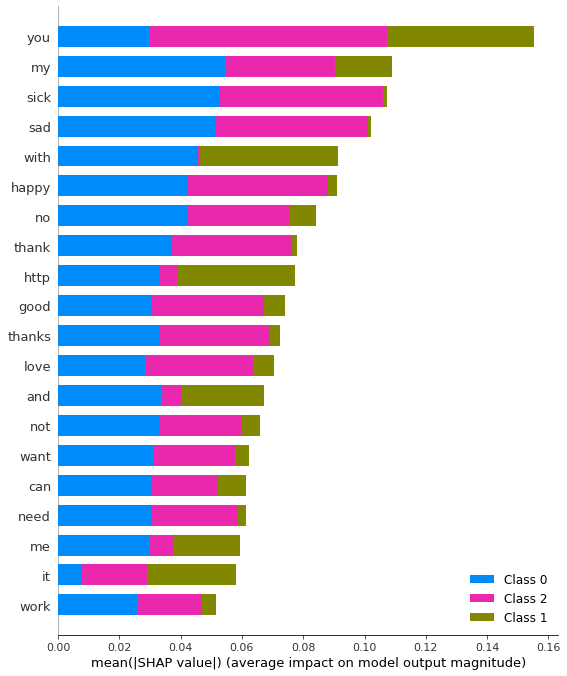

In [43]:
X_test_array = X_test_vectors_tfidf[:50].toarray()
# display importance of words according to their shap values
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=tfidf_vectorizer.get_feature_names_out(),
                  max_display=20)
